Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mean Validation Log Loss: 0.6372


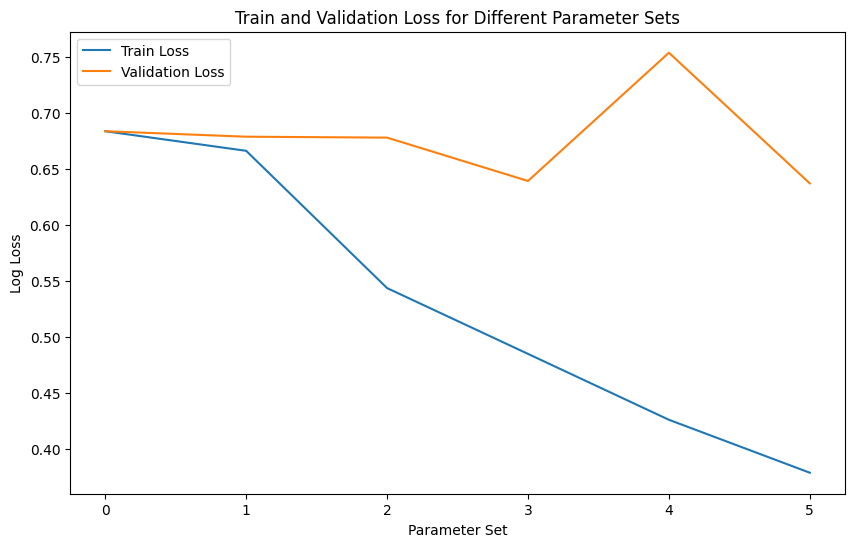

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로드
train_df = pd.read_csv('train_for_NLP.csv')
test_df = pd.read_csv('test_cleaned.csv')

# train 데이터에서 특성과 레이블 분리
X_train = train_df['combined_str']
y_train = train_df['target']  # 이진 변수: 0과 1

# test 데이터의 특성
X_test = test_df['combined_str']

# TfidfVectorizer 초기화
tfidf_vectorizer = TfidfVectorizer()

# 학습 데이터를 사용하여 TF-IDF 모델을 학습하고 임베딩
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# test 데이터에 동일한 벡터라이저를 적용
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [0.01, 0.3, 1,],  # 규제 강도
    'penalty': ['l1', 'l2'],       # 규제 유형
    'solver': ['liblinear'] # 최적화 알고리즘
}

# 로지스틱 회귀 모델 초기화
model = LogisticRegression(max_iter=1000)

# GridSearchCV 초기화
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_log_loss', verbose=1, return_train_score=True)

# 모델 학습 및 최적 파라미터 찾기
grid_search.fit(X_train_tfidf, y_train)

# 최적 파라미터 확인
print("Best Parameters:", grid_search.best_params_)

# 최적 모델로 test 데이터 예측 수행 (확률값)
best_model = grid_search.best_estimator_
y_test_pred_prob = best_model.predict_proba(X_test_tfidf)[:, 1]  # 확률 예측

# 확률을 이진 값으로 변환 (임계값 0.5)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

submission_df = pd.read_csv("sample_submission.csv")
submission_df['target'] = y_test_pred

# 예측 결과를 DataFrame으로 저장
submission_df.to_csv('submission.csv', index=False)

# Validation 데이터의 평균 Loss 출력
mean_val_loss = -grid_search.best_score_
print(f"Mean Validation Log Loss: {mean_val_loss:.4f}")

# 손실 값 시각화
num_params = len(grid_search.cv_results_['mean_train_score'])  # 파라미터 조합의 수

plt.figure(figsize=(10, 6))
plt.plot(range(num_params), -grid_search.cv_results_['mean_train_score'], label='Train Loss')
plt.plot(range(num_params), -grid_search.cv_results_['mean_test_score'], label='Validation Loss')
plt.xlabel('Parameter Set')
plt.ylabel('Log Loss')
plt.title('Train and Validation Loss for Different Parameter Sets')
plt.legend()
plt.show()
